In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from datasets import Dataset
import torch
import tensorflow as tf

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/praveen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/praveen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load the dataset

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [3]:
# Apply sentiment value 1 for positive and 0 for negative

df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
df.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
0          24698  24698  No one expects the Star Trek movies to be high...   
1          24884  24884  I thought this movie did a down right good job...   

                
          freq  
sentiment       
0            1  
1            1

In [5]:
# Dataset is balanced
df['sentiment'].value_counts()

sentiment
1    24884
0    24698
Name: count, dtype: int64

### Pre Processing

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Converting to lowercase
    text = text.lower()

    # 2. Removing punctuation, special symbols & white space
    text = re.sub('^a-zA-Z0-9',' ',text)
    text = re.sub('<.*?>',' ',text)
    text= text.translate(str.maketrans("", "", string.punctuation))

    # 3. Tokenization
    tokens = text.split()

    # 4. Removing stop words
    tokens = [token for token in tokens if token not in stop_words and token != ' ']

    # 5. Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Re-join the tokens back into a string
    processed_text = ' '.join(tokens)

    return processed_text

df['review'] = df['review'].apply(preprocess_text)

### Train - test split

In [7]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)
print(X_train.head(3))


7837     really liked movie emporers new groove watchin...
4814     decided watch movie noted scariest movie ever ...
35458    hard say going lady shanghai film could withou...
Name: review, dtype: object


### LR with Sparse Vector

In [8]:
# Creating a sparse vector using TF-IDF

vectorizer = TfidfVectorizer(max_features=25000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Fitting a Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

Logistic Regression with Sparse Vector
Logistic Regression Accuracy: 0.8932
Precision: 0.8814
Recall: 0.9096
F1 Score: 0.8953


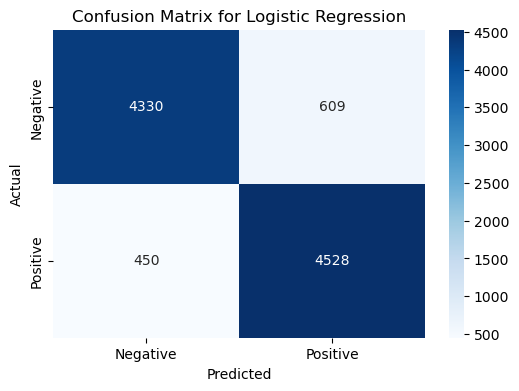

In [9]:
# Compute metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print("Logistic Regression with Sparse Vector")
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

##### Since dataset is balanced, accuracy of around 89.3% is achieved using the Logistic Regression model with Sparse vector

### DistilBERT model

In [10]:
train_data = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_data = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


def encode_data(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)


In [14]:
train_data = train_data.map(encode_data, batched=True)
test_data = test_data.map(encode_data, batched=True)

batch_size = 8
train_dataset = train_data.with_format("tensorflow").to_tf_dataset(
    columns=["input_ids", "attention_mask"], label_cols="label", batch_size=batch_size
)
test_dataset = test_data.with_format("tensorflow").to_tf_dataset(
    columns=["input_ids", "attention_mask"], label_cols="label", batch_size=batch_size
)

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_dataset, epochs=2, validation_data=test_dataset)
model.evaluate(test_dataset)

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
4959/4959 [==============================] - 696s 135ms/step - loss: 0.3405 - accuracy: 0.8524 - val_loss: 0.2795 - val_accuracy: 0.8825
Epoch 2/2
1240/1240 [==============================] - 52s 42ms/step - loss: 0.2969 - accuracy: 0.8761


[0.29690343141555786, 0.8760713934898376]

In [ ]:
train_data = train_data.map(encode_data, batched=True)
test_data = test_data.map(encode_data, batched=True)

batch_size = 8
train_dataset = train_data.with_format("tensorflow").to_tf_dataset(
    columns=["input_ids", "attention_mask"], label_cols="label", batch_size=batch_size
)
test_dataset = test_data.with_format("tensorflow").to_tf_dataset(
    columns=["input_ids", "attention_mask"], label_cols="label", batch_size=batch_size
)

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_dataset, epochs=2, validation_data=test_dataset)
model.evaluate(test_dataset)

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
4959/4959 [==============================] - 696s 135ms/step - loss: 0.3405 - accuracy: 0.8524 - val_loss: 0.2795 - val_accuracy: 0.8825
Epoch 2/2
1240/1240 [==============================] - 52s 42ms/step - loss: 0.2969 - accuracy: 0.8761


[0.29690343141555786, 0.8760713934898376]

##### With DistilBERT model (Tried Only epochs =2 because of computational expense), accuracy of around 87.6% is achieved. There is a scope for improvement in accuracy by increasing the epochs with the DistilBERT model